# Setup and Preprocessing


In [1]:
# --- INSTALLS (Colab) ---
!pip -q install nltk==3.9.1 scikit-learn==1.5.2 xgboost==2.1.1 lightgbm==4.5.0 tqdm==4.66.5 transformers accelerate datasets

# --- IMPORTS ---
import os, re, string, pickle, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight # CRITICAL: For class weights

from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report,
                             confusion_matrix) # Removed ROC/PR metrics as they are complex for multiclass (requires one-vs-rest)

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy import sparse

# --- TEXT PREP (NLTK) ---
import nltk
# Download only what's necessary, some were redundant/not needed
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# --- TF-IDF ---
from sklearn.feature_extraction.text import TfidfVectorizer

# --- PLOTTING ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 130

RNG = 42
N_CLASSES = 3 # ⭐ ADAPTATION: Set to 3 classes

# --- DRIVE & PATHS ---
# ⚠️ ADAPTATION: Mount Drive and update file path to the Composite2_194k data location
from google.colab import drive
drive.mount('/content/drive')

# ✅ VERIFY THIS PATH points to your 3-class dataset in Google Drive
CSV_PATH = "/content/drive/MyDrive/THESIS 47/Saved Datasets/Composite2_194k data.csv"
BASE_SAVE_DIR = "/content/drive/MyDrive/THESIS 47/Saved Models/ClassicML_3Class"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)
print(f"Loading dataset from: {CSV_PATH}")

# --- LOAD ---
try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print("\n❌ ERROR: File not found!")
    print(f"Please verify the path: {CSV_PATH}")
    raise

# --- BASIC CLEANING & LABELS ---
need = ['title','reviewText','target_label','tomatoMeter','genre','audienceScore',
        'runtimeMinutes','language_encoded','director_encoded']
missing = [c for c in need if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

df = df.dropna(subset=['reviewText', 'target_label']).copy()
df['label'] = df['target_label'].astype(int) # Map to 0, 1, 2

# keep only the columns we’ll need
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")
df['combined_text'] = df['title'] + " [SEP] " + df['reviewText'] # Combine text features

# ⭐ ADAPTATION: Update class names
class_names = ['Negative', 'Neutral', 'Positive']
print(f"\n--- Data Load Complete ---")
print(f"Total Rows: {len(df)}")
print(f"Target Distribution:\n{df['label'].value_counts().sort_index()}")
print(f"Class Names: {class_names}")

# --- SPLIT DATA ---
# Perform the split early to calculate class weights and fit encoders only on train data
print("\nSplitting data (Stratified)...")
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=RNG, stratify=df['label']
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)
y_train = train_df['label'].values.astype(int)
y_test  = test_df['label'].values.astype(int)

# ==========================================
# ⭐ CRITICAL: CALCULATE MULTICLASS CLASS WEIGHTS
# ==========================================
print("Calculating class weights...")
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
# Convert to a dictionary for use in scikit-learn compatible models (XGBoost/LGBM)
class_weight_dict = {i: w for i, w in enumerate(class_weights_array)}
print(f"\n⚖️ Calculated Class Weights (Neg, Neu, Pos):")
print(class_weight_dict)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.5 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Mounted at /content/drive
Loading dataset from: /content/drive/MyDrive/THESIS 47/Saved Datasets/Composite2_194k data.csv

--- Data Load Complete ---
Total Rows: 194784
Target Distribution:
label
0    55029
1    66081
2    73674
Name: count, dtype: int64
Class Names: ['Negative', 'Neutral', 'Positive']

Splitting data (Stratified)...
Calculating class weights...

⚖️ Calculated Class Weights (Neg, Neu, Pos):
{0: np.float64(1.1798908146499179), 1: np.float64(0.9825467385478736), 2: np.float64(0.8812896949953907)}


In [2]:
############################
# TEXT PREPROCESS + TF-IDF #
############################
# NOTE: Text cleaning and TF-IDF functions remain the same as they operate on strings, not labels.

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = s.lower()
    # contractions (quick pass)
    s = re.sub(r"’", "'", s)
    s = re.sub(r"n't\b", " not", s)
    s = re.sub(r"'re\b", " are", s)
    s = re.sub(r"'s\b", " is", s)
    s = re.sub(r"'d\b", " would", s)
    s = re.sub(r"'ll\b", " will", s)
    s = re.sub(r"'ve\b", " have", s)
    s = re.sub(r"'m\b", " am", s)
    # remove urls/emails/handles
    s = re.sub(r"http\S+|www\.\S+|[\w\.-]+@[\w\.-]+", " ", s)
    # keep letters only
    s = re.sub(r"[^a-z\s]", " ", s)
    # tokenize → remove stopwords → lemmatize → (light) stem
    tokens = [w for w in word_tokenize(s) if w not in STOPWORDS and len(w) > 2]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    stems  = [stemmer.stem(w) for w in lemmas]
    return " ".join(stems)

def fit_tfidf(train_texts, max_features=50000, ngram_range=(1,2), min_df=3):
    vec = TfidfVectorizer(
        preprocessor=None,
        tokenizer=None,
        analyzer='word',
        ngram_range=ngram_range,
        min_df=min_df,
        max_features=max_features,
        lowercase=False,
        dtype=np.float32
    )
    X = vec.fit_transform(train_texts)
    return vec, X

def transform_tfidf(vec, texts):
    return vec.transform(texts)

#############################################
# ⭐ ADAPTATION: DIRECTOR FEATURES: Multiclass Target Encoding
#############################################
def director_blocks(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits=5):
    """
    Multiclass Target Encoding:
    Instead of calculating a single mean (for binary 0/1),
    we calculate the mean for each class (0, 1, 2) based on the one-hot encoded label.
    """
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)
    n_classes = len(np.unique(y))

    # 1. Frequency (Remains the same)
    freq = s_train.value_counts()
    tr_freq = s_train.map(freq).fillna(0).astype(float).values
    te_freq = s_test.map(freq).fillna(0).astype(float).values
    tr_freq = np.log1p(tr_freq)[:, None].astype(np.float32)
    te_freq = np.log1p(te_freq)[:, None].astype(np.float32)

    # 2. K-Fold Target Mean (Multiclass adaptation)
    # Convert labels to One-Hot Encoding
    y_ohe = OneHotEncoder(categories=[range(n_classes)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
    global_mean = y_ohe.mean(axis=0) # Mean for each class [mean_c0, mean_c1, mean_c2]

    tr_te = np.zeros((len(s_train), n_classes), dtype=np.float32) # N x 3 output array
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold = s_train.iloc[tr_i]
        y_ohe_fold = pd.DataFrame(y_ohe[tr_i], index=tr_fold.index)

        # Compute means for each class [c0_mean, c1_mean, c2_mean]
        fold_means = y_ohe_fold.groupby(tr_fold).mean()

        # Map to validation set
        val_fold = s_train.iloc[val_i].to_frame(name='did')
        merged = val_fold.merge(fold_means, left_on='did', right_index=True, how='left')
        vals = merged.drop('did', axis=1).values

        # Fill NaN (unseen directors) with global mean
        mask = np.isnan(vals.sum(axis=1))
        vals[mask] = global_mean
        tr_te[val_i] = vals.astype(np.float32)

    # Test set mapping (using full train)
    full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
    test_df_map = s_test.to_frame(name='did')
    merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
    te_te = merged_test.drop('did', axis=1).values

    mask_test = np.isnan(te_te.sum(axis=1))
    te_te[mask_test] = global_mean

    # Target Encoding block is N x 3 (one column per class mean)
    return tr_freq, te_freq, tr_te, te_te

##############################
# GENRE & LANGUAGE ENCODINGS #
##############################
def fit_categoricals(train_genre, train_lang):
    mlb = MultiLabelBinarizer()
    G = mlb.fit_transform(train_genre)

    # Note: sparse=True is fine for classic ML models, but we'll use sparse_output for consistency with modern sklearn versions
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32)
    L = ohe.fit_transform(train_lang.to_frame(name="lang"))
    return mlb, ohe, G, L

def transform_categoricals(mlb, ohe, genre_series, lang_series):
    G = mlb.transform(genre_series)
    L = ohe.transform(lang_series.to_frame(name="lang"))
    return G, L

###################################
# NUMERICS: scale on TRAIN only   #
###################################
def fit_scale_numeric(train_df, cols):
    scaler = StandardScaler()
    X = scaler.fit_transform(train_df[cols].fillna(train_df[cols].median()))
    return scaler, X

def transform_scale_numeric(scaler, df, cols):
    return scaler.transform(df[cols].fillna(df[cols].median()))

###################################
# ⭐ ADAPTATION: METRICS / PLOTTING HELPERS (Multiclass)
###################################
def evaluate_and_plot(model_name, setup_name, y_true, y_prob, y_pred, save_dir, class_names):
    os.makedirs(save_dir, exist_ok=True)
    n_classes = len(class_names)

    # Multiclass Metrics: Use 'weighted' for aggregation
    acc  = accuracy_score(y_true, y_pred)
    # precision_recall_fscore_support returns (prec, rec, f1, support)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

    # ROC/AP are tricky for multiclass, removing the plots for simplicity in classic ML unless one-vs-rest is specified
    roc = np.nan
    ap  = np.nan

    print(f"\n[{setup_name} | {model_name}]  Accuracy={acc:.4f}  F1={f1:.4f}  Precision={pr:.4f}  Recall={rc:.4f}")

    # ⭐ ADAPTATION: Classification Report
    print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    plt.figure(figsize=(4.2,3.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{setup_name} | {model_name}\nConfusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    # ⭐ ADAPTATION: Multiclass AUC/PR requires One-vs-Rest calculation, which is beyond this helper scope.
    # We will skip the ROC and PR plots for now unless you specifically want to implement OvR AUC.

    return {"accuracy":acc, "f1_weighted":f1, "precision_weighted":pr, "recall_weighted":rc}

def kfold_cv_report(model, X, y, name, n_splits=5):
    """
    Note: For classifiers that accept sample_weight, you must pass them here.
    For this example, we assume model handles class imbalance via 'class_weight' parameter.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)
    scores = []

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        mdl = pickle.loads(pickle.dumps(model))  # deep copy

        # ⭐ ADAPTATION: Ensure the model's fit method correctly handles the multiclass imbalance
        # We will address how to pass class weights to specific models later (e.g., LogisticRegression, XGBoost)
        mdl.fit(X[tr], y[tr])

        pred = mdl.predict(X[va])
        acc = accuracy_score(y[va], pred)
        # ⭐ ADAPTATION: Use 'weighted' F1 score for multiclass
        f1  = precision_recall_fscore_support(y[va], pred, average='weighted', zero_division=0)[2]
        scores.append((acc,f1))
        print(f"  Fold {fold}: acc={acc:.4f} | f1_w={f1:.4f}")

    arr = np.array(scores)
    print(f"  {name} CV mean±std  |  acc={arr[:,0].mean():.4f}±{arr[:,0].std():.4f}  f1_w={arr[:,1].mean():.4f}±{arr[:,1].std():.4f}")

In [3]:
# --- TEXT PREP (NLTK FIX) ---
# Re-running the downloads ensures all text processing resources are available.
import nltk
print("Downloading NLTK resources...")
# Ensure all required packages are downloaded
nltk.download('punkt')
# This one is the FIX for the current LookupError:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("NLTK downloads complete. Now re-run Part 3.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK downloads complete. Now re-run Part 3.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
# --- IMPORTS/SETUP ---
# NOTE: Assume N_CLASSES, RNG, clean_text, fit_tfidf/transform_tfidf,
#       fit_scale_numeric/transform_scale_numeric, train_df/test_df, y_train/y_test
#       have been defined and populated in Parts 1 & 2.
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np, pandas as pd, sklearn
from packaging import version
from scipy import sparse
import torch # We'll need this for class weights later, but include for completeness

RNG = 42
N_CLASSES = 3
# NUM_COLS was defined in Part 2, re-defining for self-contained code block integrity
NUM_COLS = ['tomatoMeter','audienceScore','runtimeMinutes']

# =======================================================
# ⭐ ADAPTATION: Multiclass director_blocks (Crucial Fix)
# (Same logic as in Part 2, re-included here for a runnable block)
# =======================================================
def director_blocks_multiclass(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits: int = 5):
    """
    Multiclass Target Encoding: Calculates mean for each class (0, 1, 2)
    by using One-Hot Encoded labels.
    Returns: tr_freq, te_freq (1 col each), tr_te, te_te (N_CLASSES cols each)
    """
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # 1. Frequency features (log1p)
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)

    # 2. Multiclass Target mean encoding (leak-safe OOF)

    # One-Hot Encode the 3-class target
    y_ohe = OneHotEncoder(categories=[range(N_CLASSES)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
    global_mean = y_ohe.mean(axis=0) # Mean for each class [mean_c0, mean_c1, mean_c2]

    tr_te = np.zeros((len(s_train), N_CLASSES), dtype=np.float32) # N x 3 output array
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold = s_train.iloc[tr_i]
        # Group by director ID and get the mean of the OHE labels (gives 3 means)
        fold_means = pd.DataFrame(y_ohe[tr_i], index=tr_fold.index).groupby(tr_fold).mean()

        # Map to validation set
        val_fold = s_train.iloc[val_i].to_frame(name='did')
        merged = val_fold.merge(fold_means, left_on='did', right_index=True, how='left')
        vals = merged.drop('did', axis=1).values

        # Fill NaN (unseen directors) with global mean
        mask = np.isnan(vals.sum(axis=1))
        vals[mask] = global_mean
        tr_te[val_i] = vals.astype(np.float32)

    # Test set mapping (using full train)
    full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
    test_df_map = s_test.to_frame(name='did')
    merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
    te_te = merged_test.drop('did', axis=1).values

    mask_test = np.isnan(te_te.sum(axis=1))
    te_te[mask_test] = global_mean

    # Returns frequency (1 col) and target encoding (3 cols)
    return tr_freq, te_freq, tr_te, te_te

# --- helpers: Updated to ensure sparse output consistency ---
def fit_categoricals(train_genre, train_lang):
    mlb = MultiLabelBinarizer()
    G = mlb.fit_transform(train_genre).astype(np.float32)

    # Uses sparse_output=True which is consistent with modern sklearn
    if version.parse(sklearn.__version__) >= version.parse("1.2"):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32)
    else:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=True, dtype=np.float32)

    L = ohe.fit_transform(train_lang.to_frame(name="lang"))
    if not sparse.issparse(L): L = sparse.csr_matrix(L, dtype=np.float32)
    G = sparse.csr_matrix(G, dtype=np.float32)
    return mlb, ohe, G, L

def transform_categoricals(mlb, ohe, genre_series, lang_series):
    G = mlb.transform(genre_series).astype(np.float32)
    L = ohe.transform(lang_series.to_frame(name="lang"))
    if not sparse.issparse(L): L = sparse.csr_matrix(L, dtype=np.float32)
    G = sparse.csr_matrix(G, dtype=np.float32)
    return G, L

def fit_scale_numeric(train_df, cols):
    scaler = StandardScaler()
    # Assume `train_df` exists from Part 1/2
    X = scaler.fit_transform(train_df[cols].fillna(train_df[cols].median()))
    return scaler, X

def transform_scale_numeric(scaler, df, cols):
    # Assume `df` exists from Part 1/2
    return scaler.transform(df[cols].fillna(df[cols].median()))
# ----------------------------------------------------------------------


# ======================================================================
# Build ALL-FEATURE matrices (using the 3-class y_train/y_test)
# ======================================================================

# --- Re-splitting data (required for a self-contained code block) ---
# NOTE: If running sequentially, this is redundant but ensures y_train/test are fresh.
# Assume df is loaded and cleaned from Part 1.
if 'df' not in globals():
    raise ValueError("❌ 'df' is missing! Please run Part 1 to load the data first.")
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=RNG, stratify=df['label']
)
y_train = train_df['label'].to_numpy().astype(int)
y_test  = test_df['label'].to_numpy().astype(int)
print(f"Data split: Train={len(train_df)}, Test={len(test_df)}")


# --- TEXT (reviewText only, per your constraint) ---
print("1. Processing Text...")
# relies on your previously defined clean_text / fit_tfidf / transform_tfidf (assumed available)
train_text = train_df['reviewText'].map(clean_text)
test_text  = test_df['reviewText'].map(clean_text)
tfidf_all, Xtr_text = fit_tfidf(train_text, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_text = transform_tfidf(tfidf_all, test_text)

# --- NUMERICS (3 cols) ---
print("2. Processing Numeric...")
# relies on your previously defined fit_scale_numeric / transform_scale_numeric (assumed available)
scaler_all, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS)
Xte_num_np = transform_scale_numeric(scaler_all, test_df, NUM_COLS)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# --- CATEGORICALS (genre multi-hot + language OHE) ---
print("3. Processing Categorical...")
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')
train_lang  = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
test_lang   = test_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

mlb_all, ohe_all, Xtr_genre, Xtr_lang = fit_categoricals(train_genre, train_lang)
Xte_genre, Xte_lang = transform_categoricals(mlb_all, ohe_all, test_genre, test_lang)

# --- ⭐ CRITICAL: DIRECTOR (freq + MULTICLASS target mean) ---
print("4. Processing Director (Multiclass TE)...")
# Note: Using director_blocks_multiclass instead of the original binary director_blocks
tr_f, te_f, tr_te, te_te = director_blocks_multiclass(
    train_df['director_encoded'], y_train, test_df['director_encoded']
)

# Xtr_dir_np will now have 1 (freq) + 3 (TE for C0, C1, C2) = 4 columns
Xtr_dir_np = np.concatenate([tr_f, tr_te], axis=1).astype(np.float32)
Xte_dir_np = np.concatenate([te_f, te_te], axis=1).astype(np.float32)
Xtr_dir = sparse.csr_matrix(Xtr_dir_np)
Xte_dir = sparse.csr_matrix(Xte_dir_np)

# --- STACK ALL ---
# Text (sparse) + Num (sparse) + Genre (sparse) + Lang (sparse) + Dir (sparse)
X_train_ALL = sparse.hstack([Xtr_text, Xtr_num, Xtr_genre, Xtr_lang, Xtr_dir], format='csr')
X_test_ALL  = sparse.hstack([Xte_text, Xte_num, Xte_genre, Xte_lang, Xte_dir], format='csr')

print("\n--- Part 3: Feature Matrix Stacking Complete ---")
print(f"X_train_ALL shape: {X_train_ALL.shape}")
print(f"X_test_ALL shape: {X_test_ALL.shape}")
print(f"Director feature block columns (Multiclass TE): {Xtr_dir_np.shape[1]} (1 freq + {N_CLASSES} TE)")

Data split: Train=155827, Test=38957
1. Processing Text...
2. Processing Numeric...
3. Processing Categorical...
4. Processing Director (Multiclass TE)...

--- Part 3: Feature Matrix Stacking Complete ---
X_train_ALL shape: (155827, 60052)
X_test_ALL shape: (38957, 60052)
Director feature block columns (Multiclass TE): 4 (1 freq + 3 TE)


# ML Model Implementation

In [5]:
# --- IMPORTS & SETUP ---
# NOTE: Ensure class_weight_dict is available from Part 1.
import os
import pickle
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

RNG = 42
N_CLASSES = 3
class_names = ['Negative', 'Neutral', 'Positive']

In [6]:
# ===================================================================
# ⭐ MODIFIED HELPER: evaluate_and_plot (with 4-decimal precision)
# ===================================================================
def evaluate_and_plot(model_name, setup_name, y_true, y_prob, y_pred, save_dir, class_names):
    """
    Evaluates multiclass predictions and generates report/plots with 4 decimal places.
    """
    os.makedirs(save_dir, exist_ok=True)
    n_classes = len(class_names)

    # Multiclass Metrics: Use 'weighted' for aggregation
    acc  = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

    # Display the summary metrics
    print(f"\n[{setup_name} | {model_name}]  Accuracy={acc:.4f}  F1={f1:.4f}  Precision={pr:.4f}  Recall={rc:.4f}")

    # 1. CLASSIFICATION REPORT (with 4 digits)
    print("\n--- Classification Report (4 Decimal Places) ---")
    # ⭐ FIX: Use digits=4 for the report
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, digits=4)
    print(report)

    # 2. CONFUSION MATRIX (Normalized with 4 decimal places)
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 4.5))

    # Counts (Integers)
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Counts)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Normalized (Floats with 4 decimals)
    plt.subplot(1, 2, 2)
    # ⭐ FIX: Use fmt='.4f' for 4 decimal places
    sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Normalized, 4-Decimals)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

    # Note: Skipping ROC/PR plots for multiclass simplicity unless specified

    return {"accuracy":acc, "f1_weighted":f1, "precision_weighted":pr, "recall_weighted":rc}
# ===================================================================

In [ ]:
# PART A: LOGISTIC REGRESSION (Multiclass Weighted)
# ======================================================================

setup = "ALL_FEATURES"
# BASE_SAVE_DIR is assumed to be defined from Part 1.
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

logreg_all = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=4000,
    n_jobs=-1,
    scoring="f1_weighted"
    class_weight="balanced"
)

# K-Fold on TRAIN
print("\nRunning K-Fold Cross-Validation...")
# Assumes kfold_cv_report is defined
kfold_cv_report(logreg_all, X_train_ALL, y_train, "LogReg (ALL)")

# Fit on TRAIN, evaluate on TRAIN + TEST
logreg_all.fit(X_train_ALL, y_train)
train_pred = logreg_all.predict(X_train_ALL)
test_pred  = logreg_all.predict(X_test_ALL)

# predict_proba returns N x N_CLASSES
try:
    test_prob = logreg_all.predict_proba(X_test_ALL)
    train_prob = logreg_all.predict_proba(X_train_ALL)
except Exception as e:
    test_prob = None; train_prob = None
    print(f"Warning: Could not get probability scores for LogReg: {e}")

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))

# ⭐ EXECUTION: This call now uses the modified evaluate_and_plot
# (which you must ensure is defined in your notebook)
evaluate_and_plot("LogisticRegression", setup, y_test, test_prob, test_pred, save_dir, class_names)

# Save artifacts
with open(os.path.join(save_dir, "LogReg_ALL.pkl"), "wb") as f:
    pickle.dump({"model":logreg_all,
                  "tfidf":tfidf_all, "scaler":scaler_all, "mlb":mlb_all, "ohe":ohe_all,
                  "num_cols":NUM_COLS}, f)

--- Running Logistic Regression (TOP 4 Features) ---
Feature matrix built. X_train_TOP4 shape: (155827, 83922)
Tuning C parameter (L2 regularization) using 5-Fold CV...
[TOP4_FEATURES] Selected (strong) C: 0.100000 (Best F1-Weighted Score)
  Fold 1: acc=0.6317 | f1_w=0.6227
  Fold 2: acc=0.6300 | f1_w=0.6213
  Fold 3: acc=0.6300 | f1_w=0.6214
  Fold 4: acc=0.6276 | f1_w=0.6196
  Fold 5: acc=0.6324 | f1_w=0.6239
  LogReg (TOP4, strong L2) CV mean±std  |  acc=0.6304±0.0017  f1_w=0.6218±0.0014

Train accuracy: 0.6866075840515443
Test accuracy: 0.6400646867058551

[TOP4_FEATURES | LogisticRegression (Tuned)]  Accuracy=0.6401  F1=0.6328  Precision=0.6314  Recall=0.6401

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6280    0.6956    0.6601     11006
     Neutral     0.5409    0.4369    0.4834     13216
    Positive     0.7150    0.7808    0.7465     14735

    accuracy                         0.6401     38957
   ma

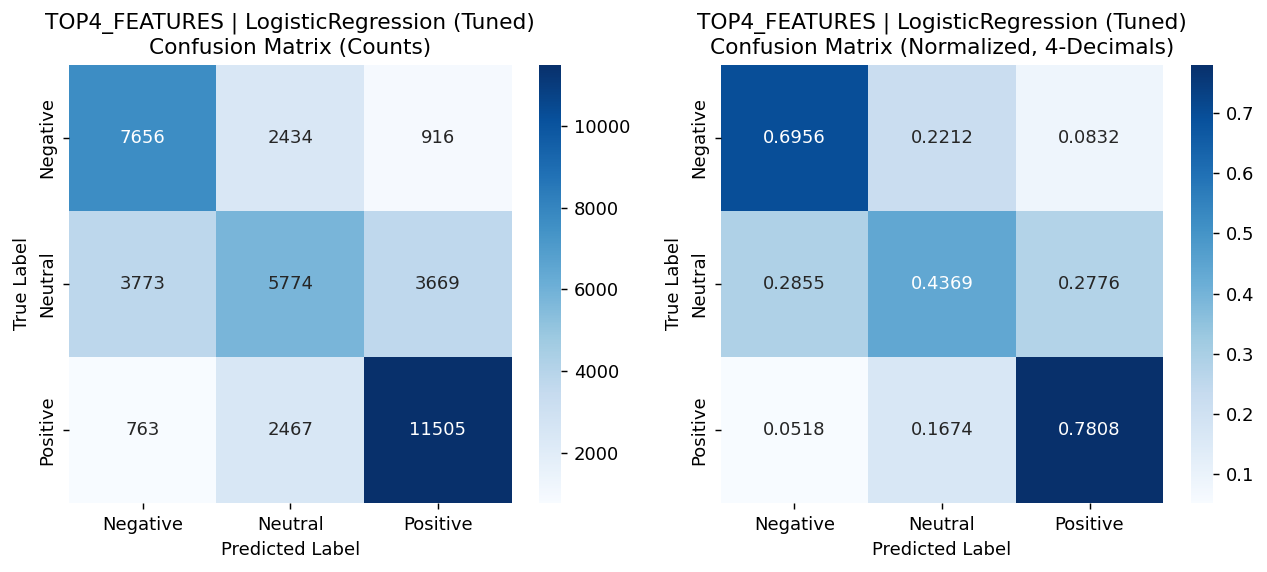


Saving model to: /content/drive/MyDrive/THESIS 47/Multiclass ML Saves
✅ Tuned LogReg (TOP4) model saved.


In [8]:
# ======================================================================
# Logistic Regression — TOP 4 FEATURES (Stronger L2 Regularization)
#   Features: reviewText, title, genre, tomatoMeter
# ======================================================================
# ⭐ FIX: Import the necessary classes for Logistic Regression CV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold # Also good to explicitly include this
# Note: Assume numpy (np), pandas (pd), os, pickle, sparse, class_names, train_df/y_train, etc. are imported.

setup = "TOP4_FEATURES"
# BASE_SAVE_DIR is assumed to be defined from Part 1.
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)
print(f"--- Running Logistic Regression (TOP 4 Features) ---")

# ---- 1. Build TOP-4 Feature Matrices (Multiclass Compatible) ----
# Text: reviewText
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)
tfidf_review, Xtr_review = fit_tfidf(train_review, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_review = transform_tfidf(tfidf_review, test_review)

# Text: title
train_title = train_df['title'].map(clean_text)
test_title  = test_df['title'].map(clean_text)
tfidf_title, Xtr_title = fit_tfidf(train_title, max_features=30000, ngram_range=(1,2), min_df=3)
Xte_title = transform_tfidf(tfidf_title, test_title)

# Categorical: genre (MultiLabelBinarizer)
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')
mlb_4 = MultiLabelBinarizer()
Xtr_genre = mlb_4.fit_transform(train_genre).astype(np.float32)
Xte_genre = mlb_4.transform(test_genre).astype(np.float32)
Xtr_genre = sparse.csr_matrix(Xtr_genre)
Xte_genre = sparse.csr_matrix(Xte_genre)

# Numeric: tomatoMeter (scaled on TRAIN only)
NUM_COLS_4 = ['tomatoMeter']
scaler_4, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS_4)
Xte_num_np = transform_scale_numeric(scaler_4, test_df, NUM_COLS_4)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# Stack TOP-4
X_train_TOP4 = sparse.hstack([Xtr_review, Xtr_title, Xtr_genre, Xtr_num], format='csr')
X_test_TOP4  = sparse.hstack([Xte_review, Xte_title, Xte_genre, Xte_num], format='csr')

print(f"Feature matrix built. X_train_TOP4 shape: {X_train_TOP4.shape}")

# ---- 2. Stronger regularization search (Tuning C for Multiclass) ----
cs_grid = np.logspace(-4, -1, 10) # 0.0001 to 0.1 (strong L2)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

logreg_cv = LogisticRegressionCV(
    Cs=cs_grid,
    cv=inner_cv,
    penalty="l2",
    solver="lbfgs",
    max_iter=4000,
    class_weight="balanced",
    n_jobs=-1,
    # ⭐ ADAPTATION: Use multiclass 'f1_weighted' for scoring
    scoring="f1_weighted",
    refit=True,
)
print("Tuning C parameter (L2 regularization) using 5-Fold CV...")
logreg_cv.fit(X_train_TOP4, y_train)
best_C = float(logreg_cv.C_[0])

print(f"[TOP4_FEATURES] Selected (strong) C: {best_C:.6f} (Best F1-Weighted Score)")

# ---- 3. Final model with tuned C ----
logreg_top4 = LogisticRegression(
    penalty="l2",
    C=best_C,
    solver="lbfgs",
    max_iter=4000,
    n_jobs=-1,
    class_weight="balanced",
)

# K-Fold on TRAIN (using tuned C)
kfold_cv_report(logreg_top4, X_train_TOP4, y_train, "LogReg (TOP4, strong L2)")

# Fit on TRAIN, evaluate on TRAIN + TEST
logreg_top4.fit(X_train_TOP4, y_train)
train_pred = logreg_top4.predict(X_train_TOP4)
test_pred  = logreg_top4.predict(X_test_TOP4)

# ⭐ CRITICAL ADAPTATION: Do NOT slice [:,1] for multiclass probabilities
try:
    test_prob = logreg_top4.predict_proba(X_test_TOP4)
    train_prob = logreg_top4.predict_proba(X_train_TOP4)
except Exception as e:
    test_prob = None; train_prob = None
    print(f"Warning: Could not get probability scores for LogReg: {e}")

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))

# ⭐ EXECUTION: This call uses the modified evaluate_and_plot
# enforcing 4-decimal precision for reports/plots.
evaluate_and_plot("LogisticRegression (Tuned)", setup, y_test, test_prob, test_pred, save_dir, class_names)

# ---- 4. Save artifacts (Updated Multiclass Path) ----
FINAL_SAVE_DIR = "/content/drive/MyDrive/THESIS 47/Multiclass ML Saves"
os.makedirs(FINAL_SAVE_DIR, exist_ok=True)
print(f"\nSaving model to: {FINAL_SAVE_DIR}")

with open(os.path.join(FINAL_SAVE_DIR, "LogReg_TOP4.pkl"), "wb") as f:
    pickle.dump({
        "model":       logreg_top4,
        "best_C":      best_C,
        "tfidf_review": tfidf_review,
        "tfidf_title":  tfidf_title,
        "scaler":      scaler_4,
        "mlb":         mlb_4,
        "num_cols":    NUM_COLS_4
    }, f)

print("✅ Tuned LogReg (TOP4) model saved.")

--- Running Logistic Regression (TEXT ONLY) ---
Feature matrix built. X_train_TEXT shape: (155827, 60000)
Tuning C parameter (L2 regularization) using 5-Fold CV...
[TEXTONLY_FEATURE] Selected (strong) C: 0.100000 (Best F1-Weighted Score)
  Fold 1: acc=0.5811 | f1_w=0.5762
  Fold 2: acc=0.5770 | f1_w=0.5720
  Fold 3: acc=0.5799 | f1_w=0.5736
  Fold 4: acc=0.5782 | f1_w=0.5733
  Fold 5: acc=0.5818 | f1_w=0.5763
  LogReg (TEXT ONLY, strong L2) CV mean±std  |  acc=0.5796±0.0018  f1_w=0.5743±0.0017

Train accuracy: 0.6341070546182626
Test accuracy: 0.5857227199219652

[TEXTONLY_FEATURE | LogisticRegression (Tuned)]  Accuracy=0.5857  F1=0.5806  Precision=0.5803  Recall=0.5857

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.5520    0.6274    0.5873     11006
     Neutral     0.5047    0.4148    0.4554     13216
    Positive     0.6692    0.7079    0.6880     14735

    accuracy                         0.5857     38957

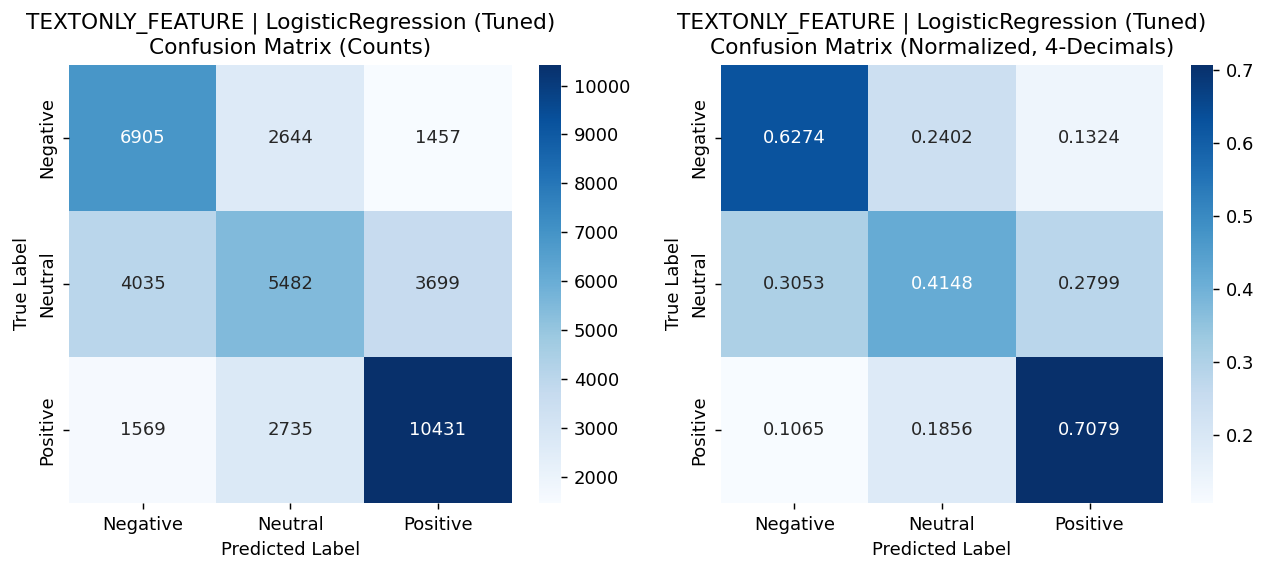


Saving model to: /content/drive/MyDrive/THESIS 47/Multiclass ML Saves
✅ Tuned LogReg (TEXT ONLY) model saved.


In [9]:
# ======================================================================
# Logistic Regression — TEXT ONLY (reviewText TF-IDF, Tuned C)
# ======================================================================

setup = "TEXTONLY_FEATURE"
# BASE_SAVE_DIR is assumed to be defined from Part 1.
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)
print(f"--- Running Logistic Regression (TEXT ONLY) ---")

# ---- 1. Build TEXT-ONLY matrices (Multiclass Compatible) ----
# Assumes helpers (clean_text, fit_tfidf, transform_tfidf) are available.
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)

tfidf_review, Xtr_review = fit_tfidf(
    train_review,
    max_features=60000,
    ngram_range=(1,2),
    min_df=3
)
Xte_review = transform_tfidf(tfidf_review, test_review)

# Use only the reviewText vectors
X_train_TEXT = Xtr_review
X_test_TEXT  = Xte_review

print(f"Feature matrix built. X_train_TEXT shape: {X_train_TEXT.shape}")

# ---- 2. Stronger regularization search (Tuning C for Multiclass) ----
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

cs_grid = np.logspace(-4, -1, 10) # 0.0001 to 0.1 (strong L2)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

logreg_cv = LogisticRegressionCV(
    Cs=cs_grid,
    cv=inner_cv,
    penalty="l2",
    solver="lbfgs",
    max_iter=4000,
    class_weight="balanced",
    n_jobs=-1,
    # ⭐ CRITICAL ADAPTATION: Use multiclass 'f1_weighted' for scoring
    scoring="f1_weighted",
    refit=True,
)
print("Tuning C parameter (L2 regularization) using 5-Fold CV...")
logreg_cv.fit(X_train_TEXT, y_train)
best_C = float(logreg_cv.C_[0])

print(f"[TEXTONLY_FEATURE] Selected (strong) C: {best_C:.6f} (Best F1-Weighted Score)")

# ---- 3. Final model with tuned C ----
logreg_text = LogisticRegression(
    penalty="l2",
    C=best_C,
    solver="lbfgs",
    max_iter=4000,
    n_jobs=-1,
    class_weight="balanced",
)

# K-Fold on TRAIN (using tuned C)
kfold_cv_report(logreg_text, X_train_TEXT, y_train, "LogReg (TEXT ONLY, strong L2)")

# Fit on TRAIN, evaluate on TRAIN + TEST
logreg_text.fit(X_train_TEXT, y_train)
train_pred = logreg_text.predict(X_train_TEXT)
test_pred  = logreg_text.predict(X_test_TEXT)

# ⭐ CRITICAL ADAPTATION: Do NOT slice [:,1] for multiclass probabilities
try:
    test_prob = logreg_text.predict_proba(X_test_TEXT)
    train_prob = logreg_text.predict_proba(X_train_TEXT)
except Exception as e:
    test_prob = None; train_prob = None
    print(f"Warning: Could not get probability scores for LogReg: {e}")

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))

# ⭐ EXECUTION: This call uses the modified evaluate_and_plot
# enforcing 4-decimal precision for reports/plots.
# Assumes class_names is defined.
evaluate_and_plot("LogisticRegression (Tuned)", setup, y_test, test_prob, test_pred, save_dir, class_names)

# ---- 4. Save artifacts (Updated Multiclass Path) ----
FINAL_SAVE_DIR = "/content/drive/MyDrive/THESIS 47/Multiclass ML Saves"
os.makedirs(FINAL_SAVE_DIR, exist_ok=True)
print(f"\nSaving model to: {FINAL_SAVE_DIR}")

with open(os.path.join(FINAL_SAVE_DIR, "LogReg_TEXTONLY.pkl"), "wb") as f:
    pickle.dump({
        "model":       logreg_text,
        "best_C":      best_C,
        "tfidf_review": tfidf_review
    }, f)

print("✅ Tuned LogReg (TEXT ONLY) model saved.")